## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

# Prepare Data
#### > Import apple stock data from AAPL.csv file, and separate it into X and y arrays
#### > Rescale data to make it more suitable for the machine learning model
#### > Split data into training and test sets, approximately 80% and 20% of the data respectively


In [2]:
# Load data
data = pd.read_csv('AAPL.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Compute 3 day moving average
data['MA_3'] = data['Close'].rolling(window=3).mean().shift(1)

X = data[['MA_3']].dropna().values
y = data['Close'].iloc[3:].values

#Rescale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

#Split data
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define Bidirectional Model

In [3]:
def create_bi_RNN_model(units=50, optimizer='adam'):
  time_step = 3  # Update the time_step to match the input sequence length
  # Build the LSTM model
  model = Sequential()
  model.add(Bidirectional(LSTM(units, return_sequences=True), input_shape=(time_step, X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(units, return_sequences=False)))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='linear'))  # Change activation to 'linear' for regression
  model.compile(loss='mean_squared_error', optimizer=optimizer)
  return model

# Create and Wrap the Model
#### > Define a tensorflow early stopping instance to be used by the model
#### > Create a model using the create_model function, wrapping it inside of a KerasRegressor, provided by the Keras library

In [4]:
#Define early stopping
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    restore_best_weights = True
)

#Wrap model
model_keras = KerasRegressor(
    model = create_bi_RNN_model,
    verbose = 1,
    epochs = 100,
    batch_size = 10,
    callbacks=[early_stopping],
    validation_split = 0.2
)

# Fit Model
#### > Define a parameter that will be used to find the best parameters in GridSearchCV
#### > Define a GridSearchCV model, using our previously-wrapped model as a base. This will be used to find the best combination of paramters
#### > Print the best results of the model

In [5]:
##Define parameter grid
param_grid = {
    'model__units': [30, 50, 100],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [10, 20, 50],
    'epochs': [10, 20, 30]
}

#Define and run model
grid = GridSearchCV(estimator=model_keras, param_grid=param_grid, n_jobs=1, cv=3, verbose=1)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score'], grid_result.cv_results_['std_test_score']):
    print("%f (%f) with: %r" % (mean_score, scores, params))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1576e-04 - val_loss: 5.3524e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3449e-05 - val_loss: 6.0632e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2580e-05 - val_loss: 4.3180e-05
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2440e-05 - val_loss: 1.7592e-05
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4293e-05 - val_loss: 1.4183e-05
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3291e-05 - val_loss: 3.0146e-05
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0918e-05 - val_loss: 3.1527e-05
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4041e-05 - val_loss: 9.4348e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2736e-05 - val_loss: 2.1586e-05
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3459e-05 - val_loss: 5.0804e-06
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2284e-04 - val_loss: 6.7425e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5763e-05 - val_loss: 8.7648e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2725e-05 - val_loss: 1.2564e-05
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2618e-05 - val_loss: 5.0476e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.8591e-06 - val_loss: 1.4147e-05
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.8802e-06 - val_loss: 3.5699e-05
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.4703e-06 - val_loss: 3.2215e-05
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.8580e-06 - val_loss: 3.3888e-05
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1284e-05 - val_loss: 6.8392e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1021e-05 - val_loss: 1.6780e-05
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 6.8115e-07 - val_loss: 3.4809e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3360e-07 - val_loss: 1.9633e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6873e-07 - val_loss: 3.0532e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5611e-07 - val_loss: 3.2291e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4279e-07 - val_loss: 2.9297e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4611e-07 - val_loss: 2.6196e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3340e-07 - val_loss: 3.7233e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3800e-07 - val_loss: 2.1181e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2667e-07 - val_loss: 2.7709e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.0083e-07 - val_loss: 2.3821e-06
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.2058e-04 - val_loss: 6.0632e-05
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3335e-05 - val_loss: 2.3526e-04
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1207e-05 - val_loss: 1.5872e-05
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0416e-05 - val_loss: 8.4680e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3166e-05 - val_loss: 3.5106e-05
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0718e-05 - val_loss: 3.8449e-05
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1470e-05 - val_loss: 6.6430e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0851e-05 - val_loss: 2.6864e-05
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3067e-05 - val_loss: 5.1553e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0304e-05 - val_loss: 5.3927e-06
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.8214e-05 - val_loss: 1.2482e-05
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3996e-05 - val_loss: 8.5593e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1821e-05 - val_loss: 1.0971e-05
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0387e-05 - val_loss: 2.1567e-05
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.7961e-06 - val_loss: 1.4268e-05
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0135e-05 - val_loss: 4.4327e-05
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1226e-05 - val_loss: 2.1667e-05
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0179e-05 - val_loss: 2.5218e-05
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0354e-05 - val_loss: 6.9859e-05
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0802e-05 - val_loss: 4.9989e-05
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.0827e-07 - val_loss: 3.0945e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2410e-07 - val_loss: 1.8907e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2671e-07 - val_loss: 2.2611e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5108e-07 - val_loss: 2.0280e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6999e-07 - val_loss: 2.8108e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5755e-07 - val_loss: 2.3010e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3342e-07 - val_loss: 4.2701e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.8959e-07 - val_loss: 2.4813e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3188e-07 - val_loss: 2.2529e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1668e-07 - val_loss: 2.7160e-06
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1400e-04 - val_loss: 2.0646e-05
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.1155e-05 - val_loss: 9.4991e-05
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.9813e-05 - val_loss: 6.8511e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3158e-05 - val_loss: 6.4063e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3370e-05 - val_loss: 1.5792e-05
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4709e-05 - val_loss: 2.0223e-04
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5748e-05 - val_loss: 2.1597e-05
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3041e-05 - val_loss: 7.3091e-05
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3539e-05 - val_loss: 1.4838e-05
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2645e-05 - val_loss: 3.6207e-05
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4873e-04 - val_loss: 6.4376e-05
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.1336e-05 - val_loss: 7.4779e-05
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7299e-05 - val_loss: 7.6151e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2459e-05 - val_loss: 6.7011e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2244e-05 - val_loss: 3.4974e-05
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1884e-05 - val_loss: 1.4076e-05
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1828e-05 - val_loss: 1.2642e-04
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.8168e-06 - val_loss: 1.7553e-04
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1181e-05 - val_loss: 3.0179e-05
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1593e-05 - val_loss: 3.1912e-05
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.2008e-07 - val_loss: 2.8489e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4185e-07 - val_loss: 3.1082e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5066e-07 - val_loss: 3.0646e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4522e-07 - val_loss: 3.9863e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7673e-07 - val_loss: 2.2047e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.8025e-07 - val_loss: 3.1301e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3700e-07 - val_loss: 2.4316e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5716e-07 - val_loss: 2.0121e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5105e-07 - val_loss: 3.4500e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3017e-07 - val_loss: 4.0542e-06
Restoring model weights from the end of the best epoch: 1.


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6357e-04 - val_loss: 0.0090
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7215e-04 - val_loss: 0.0097
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6460e-04 - val_loss: 0.0094
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6463e-04 - val_loss: 0.0094
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6165e-04 - val_loss: 0.0093
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6096e-04 - val_loss: 0.0091
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6246e-04 - val_loss: 0.0095
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 1.5488e-04 - val_loss: 0.0095
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 1.7627e-04 - val_loss: 0.0101
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6602e-04 - val_loss: 0.0097
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.8584e-04 - val_loss: 0.0094
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7885e-04 - val_loss: 0.0098
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7242e-04 - val_loss: 0.0095
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7264e-04 - val_loss: 0.0098
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7592e-04 - val_loss: 0.0092
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7606e-04 - val_loss: 0.0099
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7183e-04 - val_loss: 0.0096
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 1.7464e-04 - val_loss: 0.0101
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6964e-04 - val_loss: 0.0094
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 1.7147e-04 - val_loss: 0.0099
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.1247e-07 - val_loss: 4.7203e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4722e-07 - val_loss: 3.2796e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3959e-07 - val_loss: 4.1873e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3334e-07 - val_loss: 2.7626e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4769e-07 - val_loss: 1.7078e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2294e-07 - val_loss: 7.0066e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4714e-07 - val_loss: 1.9202e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1061e-07 - val_loss: 2.3001e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2295e-07 - val_loss: 2.7088e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3762e-07 - val_loss: 2.8644e-06
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6135e-04 - val_loss: 0.0093
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6429e-04 - val_loss: 0.0089
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6700e-04 - val_loss: 0.0094
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6573e-04 - val_loss: 0.0089
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6049e-04 - val_loss: 0.0098
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6840e-04 - val_loss: 0.0095
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7778e-04 - val_loss: 0.0097
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7316e-04 - val_loss: 0.0091
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6691e-04 - val_loss: 0.0097
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5968e-04 - val_loss: 0.0094
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7830e-04 - val_loss: 0.0097
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7456e-04 - val_loss: 0.0099
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7085e-04 - val_loss: 0.0098
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7779e-04 - val_loss: 0.0091
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6481e-04 - val_loss: 0.0092
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7315e-04 - val_loss: 0.0088
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7437e-04 - val_loss: 0.0091
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7789e-04 - val_loss: 0.0099
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6616e-04 - val_loss: 0.0092
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7167e-04 - val_loss: 0.0099
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0785e-06 - val_loss: 3.2285e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0186e-07 - val_loss: 3.4648e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1121e-07 - val_loss: 1.6813e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3359e-07 - val_loss: 1.8852e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1171e-07 - val_loss: 5.0854e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3867e-07 - val_loss: 1.7809e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5501e-07 - val_loss: 2.2846e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2030e-07 - val_loss: 1.7226e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5575e-07 - val_loss: 4.1062e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3122e-07 - val_loss: 2.6071e-06
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6232e-04 - val_loss: 0.0099
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5784e-04 - val_loss: 0.0089
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6469e-04 - val_loss: 0.0096
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6457e-04 - val_loss: 0.0098
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7359e-04 - val_loss: 0.0096
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6192e-04 - val_loss: 0.0098
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6970e-04 - val_loss: 0.0098
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6299e-04 - val_loss: 0.0097
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6233e-04 - val_loss: 0.0100
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6016e-04 - val_loss: 0.0096
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7353e-04 - val_loss: 0.0097
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7015e-04 - val_loss: 0.0094
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6732e-04 - val_loss: 0.0095
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7860e-04 - val_loss: 0.0097
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7716e-04 - val_loss: 0.0090
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6646e-04 - val_loss: 0.0089
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7384e-04 - val_loss: 0.0095
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5897e-04 - val_loss: 0.0091
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7207e-04 - val_loss: 0.0096
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7932e-04 - val_loss: 0.0097
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/10

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.3834e-07 - val_loss: 3.3535e-06
Epoch 2/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.0847e-07 - val_loss: 2.2300e-06
Epoch 3/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.0213e-07 - val_loss: 1.7321e-06
Epoch 4/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4269e-07 - val_loss: 6.6432e-06
Epoch 5/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3910e-07 - val_loss: 5.1582e-06
Epoch 6/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2692e-07 - val_loss: 5.3945e-06
Epoch 7/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2688e-07 - val_loss: 6.0489e-06
Epoch 8/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.8064e-07 - val_loss: 7.2837e-06
Epoch 9/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4281e-07 - val_loss: 3.0534e-06
Epoch 10/10
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3512e-07 - val_loss: 3.1854e-06
Restoring model weights from the end of the best epoch: 1.
292/292 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.1562e-04 - val_loss: 8.9972e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3269e-05 - val_loss: 1.5564e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2567e-05 - val_loss: 6.6965e-05
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0738e-05 - val_loss: 1.5369e-05
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4307e-05 - val_loss: 7.4921e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1015e-05 - val_loss: 4.5395e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3852e-05 - val_loss: 2.7548e-05
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1117e-05 - val_loss: 2.5467e-05
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1970e-05 - val_loss: 6.2694e-05
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0761e-05 - val_loss: 2.0700e-05
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0919e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.7928e-05 - val_loss: 8.0408e-05
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2238e-05 - val_loss: 1.2634e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0619e-05 - val_loss: 2.9936e-05
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1150e-05 - val_loss: 4.6162e-05
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.5227e-06 - val_loss: 8.7136e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.3486e-06 - val_loss: 5.3760e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.0732e-06 - val_loss: 1.3104e-05
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1240e-05 - val_loss: 2.8472e-05
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.6715e-06 - val_loss: 1.0991e-05
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.4015e-06 - val_loss: 5.1167e-05
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.2810e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.2981e-07 - val_loss: 3.2323e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2682e-07 - val_loss: 2.1910e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5651e-07 - val_loss: 2.3199e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3034e-07 - val_loss: 3.4735e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3617e-07 - val_loss: 2.1718e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1174e-07 - val_loss: 2.4528e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4549e-07 - val_loss: 2.8084e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4607e-07 - val_loss: 2.6394e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7095e-07 - val_loss: 2.3298e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2997e-07 - val_loss: 3.2550e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7435e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1389e-04 - val_loss: 6.2922e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1914e-05 - val_loss: 5.1890e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1492e-05 - val_loss: 5.7409e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.7786e-06 - val_loss: 4.6511e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.4120e-06 - val_loss: 7.7165e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.7595e-06 - val_loss: 2.2896e-05
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.9040e-06 - val_loss: 4.6663e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.5954e-06 - val_loss: 1.0771e-05
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.9141e-06 - val_loss: 4.6269e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.4627e-06 - val_loss: 1.2737e-05
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.9140e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.0913e-04 - val_loss: 8.0235e-05
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4509e-05 - val_loss: 4.0216e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2110e-05 - val_loss: 1.0829e-04
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2761e-05 - val_loss: 9.1412e-05
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2326e-05 - val_loss: 1.0320e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3004e-05 - val_loss: 1.1185e-05
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.7047e-06 - val_loss: 8.2491e-05
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1165e-05 - val_loss: 1.8111e-04
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1109e-05 - val_loss: 6.7812e-05
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1248e-05 - val_loss: 9.8804e-05
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1148e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.0005e-07 - val_loss: 3.4993e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2274e-07 - val_loss: 2.3301e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2321e-07 - val_loss: 2.1343e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3651e-07 - val_loss: 2.3180e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2334e-07 - val_loss: 3.2171e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2521e-07 - val_loss: 3.2311e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4419e-07 - val_loss: 2.3999e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3933e-07 - val_loss: 2.5906e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1663e-07 - val_loss: 2.1095e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4702e-07 - val_loss: 2.7154e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4760e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0030e-04 - val_loss: 8.3292e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2894e-05 - val_loss: 8.1846e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2726e-05 - val_loss: 8.1775e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1198e-05 - val_loss: 5.6500e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1939e-05 - val_loss: 5.8238e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2767e-05 - val_loss: 1.2051e-05
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.0406e-06 - val_loss: 1.2537e-05
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0877e-05 - val_loss: 6.1035e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0617e-05 - val_loss: 1.7249e-05
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0346e-05 - val_loss: 1.7693e-05
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0483e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.2470e-04 - val_loss: 5.8795e-05
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1326e-05 - val_loss: 2.1200e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1314e-05 - val_loss: 4.5992e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.4584e-06 - val_loss: 9.0404e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.5221e-06 - val_loss: 1.9899e-05
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.2956e-06 - val_loss: 1.3186e-05
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0441e-05 - val_loss: 1.6995e-04
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0407e-05 - val_loss: 7.1139e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.7258e-06 - val_loss: 7.6269e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0293e-05 - val_loss: 5.5520e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.8109e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 8.5641e-07 - val_loss: 2.5434e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4094e-07 - val_loss: 2.3490e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2941e-07 - val_loss: 2.6126e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2793e-07 - val_loss: 3.9945e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2922e-07 - val_loss: 2.5575e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7170e-07 - val_loss: 3.2219e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4308e-07 - val_loss: 3.3859e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4207e-07 - val_loss: 2.4179e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3492e-07 - val_loss: 3.2055e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5946e-07 - val_loss: 3.1943e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7695e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7874e-04 - val_loss: 0.0094
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6934e-04 - val_loss: 0.0095
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 1.6475e-04 - val_loss: 0.0093
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 1.7021e-04 - val_loss: 0.0097
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6830e-04 - val_loss: 0.0092
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 1.6783e-04 - val_loss: 0.0095
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 1.6196e-04 - val_loss: 0.0094
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 1.8142e-04 - val_loss: 0.0096
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 1.5644e-04 - val_loss: 0.0097
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1.6713e-04 - val_loss: 0.0095
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 1.6766e-04 - val_loss: 0.0095
Ep

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6346e-04 - val_loss: 0.0097
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6483e-04 - val_loss: 0.0094
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 1.7928e-04 - val_loss: 0.0094
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 1.7922e-04 - val_loss: 0.0098
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7775e-04 - val_loss: 0.0095
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7681e-04 - val_loss: 0.0092
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8101e-04 - val_loss: 0.0100
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7211e-04 - val_loss: 0.0090
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7526e-04 - val_loss: 0.0094
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7140e-04 - val_loss: 0.0097
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6985e-04 - val_loss: 0.0097
Epoch 11: early

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2642e-06 - val_loss: 1.8620e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3623e-07 - val_loss: 1.9073e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9768e-07 - val_loss: 2.5355e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 7.1327e-07 - val_loss: 4.2286e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2542e-07 - val_loss: 2.7130e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2359e-07 - val_loss: 3.6028e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 7.4791e-07 - val_loss: 3.0959e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3484e-07 - val_loss: 3.6691e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 7.3572e-07 - val_loss: 1.6986e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 7.6038e-07 - val_loss: 1.8081e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5981e-04 - val_loss: 0.0093
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6922e-04 - val_loss: 0.0093
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7676e-04 - val_loss: 0.0096
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6506e-04 - val_loss: 0.0092
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6470e-04 - val_loss: 0.0089
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6948e-04 - val_loss: 0.0098
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6998e-04 - val_loss: 0.0095
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6721e-04 - val_loss: 0.0094
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7052e-04 - val_loss: 0.0092
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5934e-04 - val_loss: 0.0100
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7396e-04 - val_loss: 0.0092
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.8032e-04 - val_loss: 0.0095
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7456e-04 - val_loss: 0.0094
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7862e-04 - val_loss: 0.0095
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6284e-04 - val_loss: 0.0098
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7144e-04 - val_loss: 0.0095
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7216e-04 - val_loss: 0.0096
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7664e-04 - val_loss: 0.0090
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6877e-04 - val_loss: 0.0097
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6945e-04 - val_loss: 0.0096
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7188e-04 - val_loss: 0.0097
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7092e-04 - val_loss: 0.0097
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4908e-06 - val_loss: 5.8218e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5594e-07 - val_loss: 3.0447e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2827e-07 - val_loss: 2.3744e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2221e-07 - val_loss: 5.7790e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5884e-07 - val_loss: 5.7855e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5101e-07 - val_loss: 3.9943e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2013e-07 - val_loss: 2.4026e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3088e-07 - val_loss: 3.7554e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4283e-07 - val_loss: 2.0494e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.0864e-07 - val_loss: 2.6043e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3635e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7133e-04 - val_loss: 0.0095
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5736e-04 - val_loss: 0.0097
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6789e-04 - val_loss: 0.0098
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5594e-04 - val_loss: 0.0090
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6314e-04 - val_loss: 0.0096
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6894e-04 - val_loss: 0.0096
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6154e-04 - val_loss: 0.0093
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6889e-04 - val_loss: 0.0098
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7214e-04 - val_loss: 0.0096
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5773e-04 - val_loss: 0.0093
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7251e-04 - val_loss: 0.0097
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.6490e-04 - val_loss: 0.0087
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7874e-04 - val_loss: 0.0097
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7300e-04 - val_loss: 0.0095
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6610e-04 - val_loss: 0.0097
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6538e-04 - val_loss: 0.0092
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7313e-04 - val_loss: 0.0093
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7020e-04 - val_loss: 0.0090
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6608e-04 - val_loss: 0.0097
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7177e-04 - val_loss: 0.0096
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7302e-04 - val_loss: 0.0089
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6700e-04 - val_loss: 0.0095
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2051e-06 - val_loss: 5.0444e-06
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2927e-07 - val_loss: 1.8839e-06
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2399e-07 - val_loss: 1.9560e-06
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4049e-07 - val_loss: 6.4286e-06
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4264e-07 - val_loss: 1.6942e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1669e-07 - val_loss: 5.4651e-06
Epoch 7/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1238e-07 - val_loss: 2.0779e-06
Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2845e-07 - val_loss: 3.0985e-06
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2728e-07 - val_loss: 3.1719e-06
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1237e-07 - val_loss: 1.9381e-06
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1803e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4607e-04 - val_loss: 7.0782e-05
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1711e-05 - val_loss: 5.3025e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0887e-05 - val_loss: 2.6446e-05
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.7800e-06 - val_loss: 5.0464e-05
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0374e-05 - val_loss: 1.1211e-04
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7927e-06 - val_loss: 2.0293e-05
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0919e-05 - val_loss: 3.6732e-05
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.9265e-06 - val_loss: 4.4227e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.9854e-06 - val_loss: 1.4395e-05
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0038e-05 - val_loss: 4.4505e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1624e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1344e-04 - val_loss: 4.8821e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1785e-05 - val_loss: 1.4603e-04
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5644e-05 - val_loss: 6.0268e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2470e-05 - val_loss: 1.0423e-04
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.8062e-06 - val_loss: 1.6286e-05
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.2729e-05 - val_loss: 3.9071e-05
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1463e-05 - val_loss: 6.3015e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1058e-05 - val_loss: 4.0382e-05
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0674e-05 - val_loss: 7.6456e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1083e-05 - val_loss: 2.2465e-05
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.9079e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.8409e-07 - val_loss: 2.4537e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3223e-07 - val_loss: 2.2159e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4635e-07 - val_loss: 2.5540e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2278e-07 - val_loss: 2.8451e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5017e-07 - val_loss: 3.0824e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5448e-07 - val_loss: 3.1690e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5942e-07 - val_loss: 2.6608e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4316e-07 - val_loss: 2.5018e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3759e-07 - val_loss: 2.8779e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4726e-07 - val_loss: 2.5940e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4399e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.0124e-04 - val_loss: 9.9870e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0039e-05 - val_loss: 4.3524e-05
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0270e-05 - val_loss: 1.1089e-05
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0206e-05 - val_loss: 2.2981e-05
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0025e-05 - val_loss: 6.8992e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.5063e-06 - val_loss: 1.0055e-05
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.4956e-06 - val_loss: 5.7246e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0371e-05 - val_loss: 1.8291e-05
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.8223e-06 - val_loss: 1.2705e-04
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0195e-05 - val_loss: 5.7079e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.6876e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0949e-04 - val_loss: 1.5527e-05
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3012e-05 - val_loss: 1.9513e-05
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0857e-05 - val_loss: 9.5558e-05
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1723e-05 - val_loss: 4.8520e-05
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.9519e-06 - val_loss: 4.1545e-05
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0667e-05 - val_loss: 1.9197e-05
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.3821e-06 - val_loss: 1.6762e-05
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.6746e-06 - val_loss: 1.2845e-04
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1310e-05 - val_loss: 7.5806e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1876e-05 - val_loss: 1.6241e-05
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.5669e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.5359e-06 - val_loss: 3.8058e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1818e-07 - val_loss: 3.3651e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5213e-07 - val_loss: 2.2603e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7381e-07 - val_loss: 2.3256e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4154e-07 - val_loss: 2.0530e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4852e-07 - val_loss: 3.0222e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7110e-07 - val_loss: 2.2983e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4277e-07 - val_loss: 2.9389e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.5907e-07 - val_loss: 2.9786e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3186e-07 - val_loss: 2.9081e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3729e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1280e-04 - val_loss: 1.8443e-05
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0558e-05 - val_loss: 7.9491e-05
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.3674e-06 - val_loss: 6.1755e-05
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.3713e-06 - val_loss: 8.4100e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0040e-05 - val_loss: 1.0105e-05
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.6867e-06 - val_loss: 2.8835e-05
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4021e-06 - val_loss: 6.6082e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.8830e-06 - val_loss: 4.5085e-05
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.3597e-06 - val_loss: 1.3708e-05
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.1790e-06 - val_loss: 1.5737e-05
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.1477e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.6261e-05 - val_loss: 2.4924e-05
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4507e-05 - val_loss: 3.8251e-05
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1231e-05 - val_loss: 4.3360e-05
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.3979e-05 - val_loss: 6.6651e-05
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0642e-05 - val_loss: 6.7828e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0389e-05 - val_loss: 1.2615e-05
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0701e-05 - val_loss: 9.3664e-05
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1092e-05 - val_loss: 5.9596e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1322e-05 - val_loss: 1.3731e-05
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0131e-05 - val_loss: 3.6889e-05
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.7730e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5032e-06 - val_loss: 2.6588e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.1225e-07 - val_loss: 2.2700e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3458e-07 - val_loss: 2.6087e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3203e-07 - val_loss: 2.8654e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3948e-07 - val_loss: 2.0869e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.0620e-07 - val_loss: 3.8709e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.3877e-07 - val_loss: 2.1595e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4040e-07 - val_loss: 3.9377e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4658e-07 - val_loss: 2.5644e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.9108e-07 - val_loss: 2.8916e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2400e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7065e-04 - val_loss: 0.0093
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 1.7354e-04 - val_loss: 0.0095
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 1.7629e-04 - val_loss: 0.0097
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 1.7857e-04 - val_loss: 0.0094
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 1.6256e-04 - val_loss: 0.0094
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 1.6360e-04 - val_loss: 0.0101
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 1.6913e-04 - val_loss: 0.0089
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 1.6257e-04 - val_loss: 0.0096
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 1.7370e-04 - val_loss: 0.0093
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 1.6762e-04 - val_loss: 0.0094
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 1.6545e-04 - val_loss: 0.0091

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7059e-04 - val_loss: 0.0094
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 1.6286e-04 - val_loss: 0.0095
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 1.7170e-04 - val_loss: 0.0098
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 1.6977e-04 - val_loss: 0.0096
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 1.7393e-04 - val_loss: 0.0093
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 1.6571e-04 - val_loss: 0.0093
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 1.7163e-04 - val_loss: 0.0092
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 1.7235e-04 - val_loss: 0.0098
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 1.7227e-04 - val_loss: 0.0097
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 1.7353e-04 - val_loss: 0.0097
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 1.7466e-04 - val_loss: 0.0096

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3481e-06 - val_loss: 2.4354e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 7.5793e-07 - val_loss: 3.1316e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 7.0288e-07 - val_loss: 2.0042e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 7.2169e-07 - val_loss: 2.5168e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 7.3378e-07 - val_loss: 1.7997e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 7.7777e-07 - val_loss: 1.6674e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 7.5473e-07 - val_loss: 3.7770e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 7.2845e-07 - val_loss: 4.2933e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 7.3783e-07 - val_loss: 5.2127e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 7.2334e-07 - val_loss: 5.1992e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/st

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7695e-04 - val_loss: 0.0094
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6959e-04 - val_loss: 0.0091
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5968e-04 - val_loss: 0.0092
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5784e-04 - val_loss: 0.0089
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5657e-04 - val_loss: 0.0087
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6986e-04 - val_loss: 0.0094
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6956e-04 - val_loss: 0.0097
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5684e-04 - val_loss: 0.0096
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6332e-04 - val_loss: 0.0092
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6710e-04 - val_loss: 0.0096
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7050e-04 - val_loss: 0.0095
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7776e-04 - val_loss: 0.0097
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5998e-04 - val_loss: 0.0101
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6504e-04 - val_loss: 0.0097
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7634e-04 - val_loss: 0.0100
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6986e-04 - val_loss: 0.0094
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6316e-04 - val_loss: 0.0095
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6737e-04 - val_loss: 0.0095
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7208e-04 - val_loss: 0.0095
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6490e-04 - val_loss: 0.0098
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6576e-04 - val_loss: 0.0097
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7309e-04 - val_loss: 0.0094
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.4094e-07 - val_loss: 3.1068e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5240e-07 - val_loss: 1.7790e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6518e-07 - val_loss: 2.0965e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6115e-07 - val_loss: 1.8231e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4446e-07 - val_loss: 2.8066e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2743e-07 - val_loss: 3.0162e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1030e-07 - val_loss: 2.9149e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7727e-07 - val_loss: 2.2389e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8918e-07 - val_loss: 1.6863e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4367e-07 - val_loss: 4.4192e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2342e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6427e-04 - val_loss: 0.0094
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6751e-04 - val_loss: 0.0091
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6338e-04 - val_loss: 0.0091
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6440e-04 - val_loss: 0.0095
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6654e-04 - val_loss: 0.0090
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6779e-04 - val_loss: 0.0094
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7073e-04 - val_loss: 0.0093
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5968e-04 - val_loss: 0.0093
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.5981e-04 - val_loss: 0.0096
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6339e-04 - val_loss: 0.0097
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.8004e-04 - val_loss: 0.0091
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7728e-04 - val_loss: 0.0098
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7119e-04 - val_loss: 0.0099
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6643e-04 - val_loss: 0.0101
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6933e-04 - val_loss: 0.0092
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6805e-04 - val_loss: 0.0089
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7036e-04 - val_loss: 0.0097
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6155e-04 - val_loss: 0.0099
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6340e-04 - val_loss: 0.0098
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7912e-04 - val_loss: 0.0093
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6525e-04 - val_loss: 0.0089
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7237e-04 - val_loss: 0.0094
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


467/467 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 9.4659e-07 - val_loss: 2.3608e-06
Epoch 2/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2681e-07 - val_loss: 6.3901e-06
Epoch 3/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3757e-07 - val_loss: 2.1873e-06
Epoch 4/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2360e-07 - val_loss: 1.9566e-06
Epoch 5/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5870e-07 - val_loss: 6.5878e-06
Epoch 6/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1760e-07 - val_loss: 5.7661e-06
Epoch 7/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3605e-07 - val_loss: 1.9372e-06
Epoch 8/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.1886e-07 - val_loss: 2.9387e-06
Epoch 9/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2784e-07 - val_loss: 2.8483e-06
Epoch 10/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.5208e-07 - val_loss: 1.9332e-06
Epoch 11/30
467/467 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2708e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2226e-04 - val_loss: 4.6287e-05
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2934e-06 - val_loss: 9.0833e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0008e-05 - val_loss: 6.0347e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0050e-05 - val_loss: 3.1109e-05
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4077e-06 - val_loss: 2.1489e-05
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5635e-06 - val_loss: 4.5285e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5387e-06 - val_loss: 5.9931e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4271e-06 - val_loss: 1.0867e-05
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6547e-06 - val_loss: 1.7383e-05
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9870e-06 - val_loss: 1.5415e-05
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4325e-04 - val_loss: 7.3251e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4527e-05 - val_loss: 7.6739e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1062e-05 - val_loss: 4.6926e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8427e-06 - val_loss: 1.9879e-05
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1894e-05 - val_loss: 5.2445e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0002e-05 - val_loss: 1.5364e-05
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6045e-06 - val_loss: 1.8091e-05
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0951e-06 - val_loss: 5.0732e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4668e-06 - val_loss: 4.3644e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4888e-06 - val_loss: 5.3592e-05
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6071e-06 - val_loss: 2.7960e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7906e-07 - val_loss: 3.3225e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9555e-07 - val_loss: 2.0309e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3566e-07 - val_loss: 2.7686e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9973e-07 - val_loss: 2.3978e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0943e-07 - val_loss: 3.0172e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1201e-07 - val_loss: 3.0676e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2469e-07 - val_loss: 3.0677e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4523e-07 - val_loss: 3.7501e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5523e-07 - val_loss: 2.5045e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4174e-04 - val_loss: 9.2652e-05
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5589e-05 - val_loss: 8.3344e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0647e-05 - val_loss: 3.5330e-05
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0878e-05 - val_loss: 1.5046e-05
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2406e-05 - val_loss: 1.0560e-05
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7146e-06 - val_loss: 9.1334e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3159e-06 - val_loss: 1.9790e-05
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5906e-06 - val_loss: 1.2504e-05
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0963e-05 - val_loss: 9.5582e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3862e-06 - val_loss: 4.1607e-05
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4117e-04 - val_loss: 1.1949e-04
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5325e-05 - val_loss: 2.2210e-05
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6912e-05 - val_loss: 9.9798e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1321e-05 - val_loss: 1.0808e-05
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1498e-05 - val_loss: 8.1098e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2134e-05 - val_loss: 2.7493e-05
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0571e-05 - val_loss: 1.3065e-05
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2256e-06 - val_loss: 1.6167e-05
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5626e-06 - val_loss: 9.3916e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4801e-06 - val_loss: 5.0499e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1055e-06 - val_loss: 1.9343e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4868e-07 - val_loss: 2.7431e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9491e-07 - val_loss: 3.1426e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0904e-07 - val_loss: 3.9167e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1004e-07 - val_loss: 1.8327e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0093e-07 - val_loss: 4.1830e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5218e-07 - val_loss: 4.5512e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6676e-07 - val_loss: 2.1222e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3675e-07 - val_loss: 2.5338e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3367e-07 - val_loss: 2.6837e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3099e-04 - val_loss: 2.6234e-05
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0866e-05 - val_loss: 1.1603e-05
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3612e-06 - val_loss: 7.0443e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3711e-06 - val_loss: 6.5501e-05
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6334e-06 - val_loss: 1.1160e-05
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4435e-06 - val_loss: 2.8264e-05
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8558e-06 - val_loss: 2.8485e-05
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5923e-06 - val_loss: 2.5470e-05
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4989e-06 - val_loss: 1.9325e-05
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6615e-06 - val_loss: 2.2865e-05
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5606e-04 - val_loss: 5.1785e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2046e-05 - val_loss: 1.6883e-05
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0719e-05 - val_loss: 4.7221e-05
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2226e-05 - val_loss: 7.7327e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1832e-05 - val_loss: 7.5504e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0536e-05 - val_loss: 5.9301e-05
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2168e-05 - val_loss: 4.0788e-05
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2300e-05 - val_loss: 4.7471e-05
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1555e-05 - val_loss: 6.9057e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2348e-06 - val_loss: 4.6271e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1964e-06 - val_loss: 2.5964e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9623e-07 - val_loss: 2.4225e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4420e-07 - val_loss: 3.4006e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9204e-07 - val_loss: 3.7606e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0631e-07 - val_loss: 4.9985e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6622e-07 - val_loss: 2.3942e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1118e-07 - val_loss: 3.5190e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8162e-07 - val_loss: 3.1508e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0950e-07 - val_loss: 2.5722e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1840e-07 - val_loss: 3.1069e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6313e-04 - val_loss: 0.0096
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6733e-04 - val_loss: 0.0099
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6789e-04 - val_loss: 0.0094
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6069e-04 - val_loss: 0.0093
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6558e-04 - val_loss: 0.0086
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6656e-04 - val_loss: 0.0094
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6203e-04 - val_loss: 0.0099
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1.6677e-04 - val_loss: 0.0097
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6448e-04 - val_loss: 0.0092
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6648e-04 - val_loss: 0.0088
Restoring model weights from the end of the best epoch: 5.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.9733e-04 - val_loss: 0.0093
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6961e-04 - val_loss: 0.0093
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7497e-04 - val_loss: 0.0092
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7359e-04 - val_loss: 0.0094
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6416e-04 - val_loss: 0.0096
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7063e-04 - val_loss: 0.0093
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6535e-04 - val_loss: 0.0095
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6609e-04 - val_loss: 0.0093
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6890e-04 - val_loss: 0.0098
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6969e-04 - val_loss: 0.0095
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6350e-06 - val_loss: 2.7047e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0031e-07 - val_loss: 2.5104e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1651e-07 - val_loss: 6.1990e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4179e-07 - val_loss: 5.4003e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2590e-07 - val_loss: 6.0453e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2939e-07 - val_loss: 1.9619e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1092e-07 - val_loss: 2.4023e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0267e-07 - val_loss: 4.2564e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2822e-07 - val_loss: 1.7321e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2496e-07 - val_loss: 4.5012e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7663e-04 - val_loss: 0.0092
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5897e-04 - val_loss: 0.0095
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6752e-04 - val_loss: 0.0097
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5974e-04 - val_loss: 0.0088
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5406e-04 - val_loss: 0.0092
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6711e-04 - val_loss: 0.0088
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6505e-04 - val_loss: 0.0095
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5408e-04 - val_loss: 0.0095
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6822e-04 - val_loss: 0.0094
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6898e-04 - val_loss: 0.0090
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7571e-04 - val_loss: 0.0095
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7055e-04 - val_loss: 0.0092
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6483e-04 - val_loss: 0.0099
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7207e-04 - val_loss: 0.0094
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7014e-04 - val_loss: 0.0091
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8131e-04 - val_loss: 0.0100
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6704e-04 - val_loss: 0.0093
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6820e-04 - val_loss: 0.0098
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6349e-04 - val_loss: 0.0097
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6635e-04 - val_loss: 0.0100
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3294e-06 - val_loss: 3.8203e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1909e-07 - val_loss: 5.2781e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0102e-07 - val_loss: 6.2816e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1557e-07 - val_loss: 3.3208e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7924e-07 - val_loss: 5.4474e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7298e-07 - val_loss: 3.7373e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1234e-07 - val_loss: 3.5575e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5267e-07 - val_loss: 1.7815e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7848e-07 - val_loss: 4.2462e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1671e-07 - val_loss: 2.0759e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7703e-04 - val_loss: 0.0096
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6108e-04 - val_loss: 0.0097
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6870e-04 - val_loss: 0.0091
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6986e-04 - val_loss: 0.0091
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6509e-04 - val_loss: 0.0096
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7511e-04 - val_loss: 0.0090
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6198e-04 - val_loss: 0.0090
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6823e-04 - val_loss: 0.0098
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6172e-04 - val_loss: 0.0092
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6983e-04 - val_loss: 0.0089
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7225e-04 - val_loss: 0.0093
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6793e-04 - val_loss: 0.0094
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7769e-04 - val_loss: 0.0091
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6640e-04 - val_loss: 0.0092
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7387e-04 - val_loss: 0.0095
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6581e-04 - val_loss: 0.0098
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7233e-04 - val_loss: 0.0097
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7217e-04 - val_loss: 0.0099
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6623e-04 - val_loss: 0.0100
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6578e-04 - val_loss: 0.0098
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2312e-06 - val_loss: 1.7003e-06
Epoch 2/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8570e-07 - val_loss: 2.1365e-06
Epoch 3/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5398e-07 - val_loss: 6.6820e-06
Epoch 4/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2770e-07 - val_loss: 3.5076e-06
Epoch 5/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8945e-07 - val_loss: 6.3794e-06
Epoch 6/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0812e-07 - val_loss: 3.7067e-06
Epoch 7/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2185e-07 - val_loss: 1.9393e-06
Epoch 8/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3324e-07 - val_loss: 4.0367e-06
Epoch 9/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0688e-07 - val_loss: 8.6977e-06
Epoch 10/10
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5637e-07 - val_loss: 2.9329e-06
Restoring model weights from the end of the best epoch: 1.
146/146 ━━━

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.4334e-04 - val_loss: 1.6543e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4927e-05 - val_loss: 1.0392e-05
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3225e-05 - val_loss: 6.4688e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1584e-05 - val_loss: 1.1303e-05
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0514e-05 - val_loss: 6.7817e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0436e-05 - val_loss: 5.4429e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6082e-06 - val_loss: 2.7715e-05
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0440e-05 - val_loss: 5.9241e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4303e-06 - val_loss: 4.9235e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6420e-06 - val_loss: 1.3262e-05
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8510e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.2813e-04 - val_loss: 2.4534e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3928e-05 - val_loss: 6.4681e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0344e-05 - val_loss: 6.2436e-05
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4608e-06 - val_loss: 1.0284e-05
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0636e-05 - val_loss: 1.9920e-05
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5364e-06 - val_loss: 1.0896e-05
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4704e-06 - val_loss: 1.7504e-05
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0642e-05 - val_loss: 2.7892e-05
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8822e-06 - val_loss: 5.5689e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0617e-05 - val_loss: 5.9391e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9574e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.3790e-07 - val_loss: 2.6223e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1328e-07 - val_loss: 2.9249e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0183e-07 - val_loss: 2.6761e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1408e-07 - val_loss: 2.7096e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9851e-07 - val_loss: 2.7444e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0724e-07 - val_loss: 2.6656e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8739e-07 - val_loss: 3.3003e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9993e-07 - val_loss: 2.5972e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0404e-07 - val_loss: 4.3915e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5913e-07 - val_loss: 2.6308e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1119e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5805e-04 - val_loss: 1.1334e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4293e-05 - val_loss: 4.0783e-05
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0114e-05 - val_loss: 1.8817e-05
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6977e-06 - val_loss: 1.6121e-05
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0280e-05 - val_loss: 1.2555e-05
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8210e-06 - val_loss: 1.3805e-05
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2649e-06 - val_loss: 7.3414e-05
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8721e-06 - val_loss: 4.4924e-05
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6273e-06 - val_loss: 1.0260e-05
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5234e-06 - val_loss: 4.7030e-05
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2303e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4907e-04 - val_loss: 1.4982e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2618e-05 - val_loss: 2.9317e-05
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1623e-05 - val_loss: 9.9750e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0055e-05 - val_loss: 2.5162e-05
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0885e-05 - val_loss: 5.2340e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0619e-05 - val_loss: 5.7105e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0684e-06 - val_loss: 8.0962e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.9191e-06 - val_loss: 6.6426e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1404e-05 - val_loss: 8.3763e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1433e-05 - val_loss: 1.4192e-05
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6307e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4305e-06 - val_loss: 3.1429e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2264e-07 - val_loss: 2.3438e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2004e-07 - val_loss: 2.5107e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2080e-07 - val_loss: 3.1936e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2859e-07 - val_loss: 2.5008e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2102e-07 - val_loss: 3.2684e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1805e-07 - val_loss: 2.3608e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2450e-07 - val_loss: 2.4064e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0673e-07 - val_loss: 2.8676e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9505e-07 - val_loss: 2.5482e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2076e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5331e-04 - val_loss: 8.3895e-05
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4958e-05 - val_loss: 6.5819e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0981e-05 - val_loss: 2.7566e-05
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0309e-05 - val_loss: 6.5443e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5278e-06 - val_loss: 6.0481e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9922e-06 - val_loss: 7.0433e-05
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3216e-06 - val_loss: 1.1677e-05
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7837e-06 - val_loss: 3.0012e-05
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9136e-06 - val_loss: 2.4732e-05
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1466e-05 - val_loss: 4.7775e-05
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1129e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3555e-04 - val_loss: 6.0973e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5147e-05 - val_loss: 4.5332e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2836e-05 - val_loss: 4.5945e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4727e-05 - val_loss: 1.2482e-05
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4098e-06 - val_loss: 4.0700e-05
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8672e-06 - val_loss: 6.5742e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5930e-06 - val_loss: 7.3399e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4308e-06 - val_loss: 1.8986e-05
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3888e-06 - val_loss: 2.1551e-05
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2623e-06 - val_loss: 4.0219e-05
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.0941e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.7707e-07 - val_loss: 3.3075e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0911e-07 - val_loss: 2.5346e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.4873e-07 - val_loss: 2.4159e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3622e-07 - val_loss: 3.1517e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4200e-07 - val_loss: 3.3055e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2528e-07 - val_loss: 2.8501e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8124e-07 - val_loss: 2.7375e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9253e-07 - val_loss: 4.1668e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6724e-07 - val_loss: 3.3082e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0370e-07 - val_loss: 3.1164e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8103e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.5963e-04 - val_loss: 0.0096
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6159e-04 - val_loss: 0.0091
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5192e-04 - val_loss: 0.0091
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7839e-04 - val_loss: 0.0099
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6691e-04 - val_loss: 0.0096
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7349e-04 - val_loss: 0.0098
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6759e-04 - val_loss: 0.0092
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7012e-04 - val_loss: 0.0093
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6109e-04 - val_loss: 0.0096
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6713e-04 - val_loss: 0.0090
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5714e-04 - val_loss: 0.0095
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6688e-04 - val_loss: 0.0089
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7358e-04 - val_loss: 0.0094
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7418e-04 - val_loss: 0.0086
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7120e-04 - val_loss: 0.0094
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6023e-04 - val_loss: 0.0094
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6245e-04 - val_loss: 0.0092
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7757e-04 - val_loss: 0.0099
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6830e-04 - val_loss: 0.0095
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7171e-04 - val_loss: 0.0090
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6500e-04 - val_loss: 0.0092
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6043e-04 - val_loss: 0.0097
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.1291e-06 - val_loss: 1.7932e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0063e-07 - val_loss: 5.9421e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3447e-07 - val_loss: 6.8052e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1031e-07 - val_loss: 3.0961e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9511e-07 - val_loss: 4.5388e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1230e-07 - val_loss: 2.0340e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8863e-07 - val_loss: 2.2910e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8473e-07 - val_loss: 2.1732e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0358e-07 - val_loss: 6.0529e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3126e-07 - val_loss: 2.6135e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9630e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7613e-04 - val_loss: 0.0095
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5775e-04 - val_loss: 0.0091
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8097e-04 - val_loss: 0.0101
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5918e-04 - val_loss: 0.0088
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7055e-04 - val_loss: 0.0094
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6482e-04 - val_loss: 0.0093
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6245e-04 - val_loss: 0.0099
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6710e-04 - val_loss: 0.0097
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6531e-04 - val_loss: 0.0091
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6365e-04 - val_loss: 0.0101
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6247e-04 - val_loss: 0.0088
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.8241e-04 - val_loss: 0.0093
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7105e-04 - val_loss: 0.0099
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7401e-04 - val_loss: 0.0100
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7572e-04 - val_loss: 0.0091
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7700e-04 - val_loss: 0.0102
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7864e-04 - val_loss: 0.0095
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7239e-04 - val_loss: 0.0090
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7797e-04 - val_loss: 0.0094
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6498e-04 - val_loss: 0.0089
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7509e-04 - val_loss: 0.0100
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7886e-04 - val_loss: 0.0100
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.4906e-06 - val_loss: 1.6801e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4241e-07 - val_loss: 1.8482e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0773e-07 - val_loss: 3.1360e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8277e-07 - val_loss: 2.0892e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0203e-07 - val_loss: 6.2610e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4063e-07 - val_loss: 6.4577e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1076e-07 - val_loss: 1.6914e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3685e-07 - val_loss: 2.1141e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9143e-07 - val_loss: 4.0973e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0988e-07 - val_loss: 5.1627e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8203e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7156e-04 - val_loss: 0.0094
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6315e-04 - val_loss: 0.0094
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6831e-04 - val_loss: 0.0097
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6387e-04 - val_loss: 0.0098
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6342e-04 - val_loss: 0.0096
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6454e-04 - val_loss: 0.0092
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6771e-04 - val_loss: 0.0089
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6922e-04 - val_loss: 0.0092
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7458e-04 - val_loss: 0.0093
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6879e-04 - val_loss: 0.0093
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6934e-04 - val_loss: 0.0096
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7128e-04 - val_loss: 0.0099
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6669e-04 - val_loss: 0.0100
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7046e-04 - val_loss: 0.0096
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6670e-04 - val_loss: 0.0099
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6318e-04 - val_loss: 0.0094
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8033e-04 - val_loss: 0.0096
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6958e-04 - val_loss: 0.0095
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7466e-04 - val_loss: 0.0090
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7698e-04 - val_loss: 0.0094
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7170e-04 - val_loss: 0.0093
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7423e-04 - val_loss: 0.0088
Epoch 12/20
234/234

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3995e-06 - val_loss: 1.6909e-06
Epoch 2/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3853e-07 - val_loss: 4.3905e-06
Epoch 3/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1116e-07 - val_loss: 3.1937e-06
Epoch 4/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3516e-07 - val_loss: 2.5902e-06
Epoch 5/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0210e-07 - val_loss: 3.3041e-06
Epoch 6/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8020e-07 - val_loss: 2.9384e-06
Epoch 7/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0918e-07 - val_loss: 2.8852e-06
Epoch 8/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0254e-07 - val_loss: 4.1497e-06
Epoch 9/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0980e-07 - val_loss: 1.9100e-06
Epoch 10/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2309e-07 - val_loss: 4.9523e-06
Epoch 11/20
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3896e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3074e-04 - val_loss: 9.8276e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1363e-05 - val_loss: 4.6306e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1104e-05 - val_loss: 4.4111e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0939e-06 - val_loss: 1.9095e-05
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8563e-06 - val_loss: 4.4092e-05
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6018e-06 - val_loss: 1.2796e-05
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6446e-06 - val_loss: 4.3512e-05
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1014e-06 - val_loss: 4.1131e-05
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8444e-06 - val_loss: 5.6029e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2778e-06 - val_loss: 7.5445e-05
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9183e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.3883e-04 - val_loss: 9.8708e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3538e-05 - val_loss: 6.7773e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2576e-05 - val_loss: 5.2436e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6332e-06 - val_loss: 1.3624e-05
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4550e-06 - val_loss: 1.0897e-05
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0703e-05 - val_loss: 1.2049e-05
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8047e-06 - val_loss: 7.7432e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0421e-05 - val_loss: 5.1856e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8537e-06 - val_loss: 5.9423e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2772e-06 - val_loss: 6.0248e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8746e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0970e-06 - val_loss: 3.7492e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0291e-07 - val_loss: 3.5247e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0860e-07 - val_loss: 2.4854e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1585e-07 - val_loss: 2.6315e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0646e-07 - val_loss: 3.5265e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2094e-07 - val_loss: 2.3485e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5571e-07 - val_loss: 2.5733e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3679e-07 - val_loss: 3.1325e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1404e-07 - val_loss: 2.5615e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1555e-07 - val_loss: 3.9596e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6813e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4274e-04 - val_loss: 5.7272e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4564e-05 - val_loss: 1.3750e-05
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3721e-05 - val_loss: 1.5517e-05
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0323e-05 - val_loss: 1.0491e-05
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0138e-05 - val_loss: 2.2664e-05
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0671e-06 - val_loss: 7.0082e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1094e-05 - val_loss: 2.0735e-05
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0606e-06 - val_loss: 4.9233e-05
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.9450e-06 - val_loss: 6.5159e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1207e-05 - val_loss: 8.1379e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0329e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.4701e-04 - val_loss: 1.1410e-05
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1653e-05 - val_loss: 4.8070e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0407e-05 - val_loss: 4.1198e-05
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1220e-06 - val_loss: 4.5554e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9130e-06 - val_loss: 7.4468e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8144e-06 - val_loss: 1.5906e-05
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8702e-06 - val_loss: 9.3660e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7042e-06 - val_loss: 4.5180e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9990e-06 - val_loss: 7.5480e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8363e-06 - val_loss: 1.2820e-05
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7476e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 8.4567e-07 - val_loss: 2.8983e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0007e-07 - val_loss: 2.9301e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2690e-07 - val_loss: 3.2937e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0860e-07 - val_loss: 2.4614e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2650e-07 - val_loss: 3.2145e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0900e-07 - val_loss: 3.2001e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1883e-07 - val_loss: 2.8501e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9762e-07 - val_loss: 2.8721e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5244e-07 - val_loss: 2.0187e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6809e-07 - val_loss: 2.4656e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0140e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.3650e-04 - val_loss: 1.3024e-05
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5927e-05 - val_loss: 3.7471e-05
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4214e-05 - val_loss: 1.6356e-05
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1217e-05 - val_loss: 3.0973e-05
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0863e-05 - val_loss: 3.6416e-05
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8402e-06 - val_loss: 5.2167e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9368e-06 - val_loss: 1.2690e-05
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6990e-06 - val_loss: 7.4220e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9826e-06 - val_loss: 8.5946e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5252e-06 - val_loss: 4.8981e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9085e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.2159e-04 - val_loss: 5.6657e-05
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0197e-05 - val_loss: 1.1082e-05
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8713e-06 - val_loss: 8.6034e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5175e-06 - val_loss: 1.8049e-05
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8614e-06 - val_loss: 5.9683e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6700e-06 - val_loss: 6.5484e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4580e-06 - val_loss: 2.0867e-05
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1189e-06 - val_loss: 2.0091e-05
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2099e-06 - val_loss: 5.4968e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2829e-06 - val_loss: 6.5882e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0179e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0038e-06 - val_loss: 3.0939e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9321e-07 - val_loss: 2.4711e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1270e-07 - val_loss: 3.0972e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1899e-07 - val_loss: 2.6478e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1814e-07 - val_loss: 1.9478e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4701e-07 - val_loss: 2.7247e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2113e-07 - val_loss: 2.2690e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7545e-07 - val_loss: 3.7112e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9775e-07 - val_loss: 2.1505e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6288e-07 - val_loss: 1.9080e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6431e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6025e-04 - val_loss: 0.0095
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6134e-04 - val_loss: 0.0101
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6115e-04 - val_loss: 0.0086
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6472e-04 - val_loss: 0.0095
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6958e-04 - val_loss: 0.0096
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6805e-04 - val_loss: 0.0092
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6056e-04 - val_loss: 0.0093
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5722e-04 - val_loss: 0.0100
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6417e-04 - val_loss: 0.0089
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5475e-04 - val_loss: 0.0098
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6855e-04 - val_loss: 0.0102
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7498e-04 - val_loss: 0.0098
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 1.6337e-04 - val_loss: 0.0087
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 1.6765e-04 - val_loss: 0.0097
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7255e-04 - val_loss: 0.0099
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6996e-04 - val_loss: 0.0094
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7596e-04 - val_loss: 0.0093
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7357e-04 - val_loss: 0.0097
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7365e-04 - val_loss: 0.0098
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6016e-04 - val_loss: 0.0092
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 1.7162e-04 - val_loss: 0.0090
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7225e-04 - val_loss: 0.0091
Epoch 12/30


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6192e-06 - val_loss: 5.7652e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1549e-07 - val_loss: 2.2280e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7588e-07 - val_loss: 5.1223e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2949e-07 - val_loss: 5.9473e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3044e-07 - val_loss: 2.5425e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8461e-07 - val_loss: 1.9010e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2083e-07 - val_loss: 3.5925e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4322e-07 - val_loss: 1.7057e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2883e-07 - val_loss: 2.0250e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9663e-07 - val_loss: 4.5379e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9293e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.7091e-04 - val_loss: 0.0097
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6387e-04 - val_loss: 0.0099
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7061e-04 - val_loss: 0.0091
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6395e-04 - val_loss: 0.0092
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6890e-04 - val_loss: 0.0101
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6802e-04 - val_loss: 0.0099
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7036e-04 - val_loss: 0.0098
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5122e-04 - val_loss: 0.0090
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6361e-04 - val_loss: 0.0089
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6414e-04 - val_loss: 0.0096
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6530e-04 - val_loss: 0.0093
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.7170e-04 - val_loss: 0.0091
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6883e-04 - val_loss: 0.0093
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7325e-04 - val_loss: 0.0094
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8185e-04 - val_loss: 0.0104
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7012e-04 - val_loss: 0.0094
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6637e-04 - val_loss: 0.0098
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6928e-04 - val_loss: 0.0094
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7012e-04 - val_loss: 0.0095
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6919e-04 - val_loss: 0.0095
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7601e-04 - val_loss: 0.0096
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5967e-04 - val_loss: 0.0092
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.6724e-06 - val_loss: 2.9155e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1588e-07 - val_loss: 6.0695e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6917e-07 - val_loss: 3.4860e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0593e-07 - val_loss: 2.5779e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2703e-07 - val_loss: 2.3696e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9920e-07 - val_loss: 5.6814e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1818e-07 - val_loss: 4.7503e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1487e-07 - val_loss: 5.2889e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1416e-07 - val_loss: 1.7191e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5934e-07 - val_loss: 4.5378e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8849e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7910e-04 - val_loss: 0.0100
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6173e-04 - val_loss: 0.0093
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6825e-04 - val_loss: 0.0095
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6460e-04 - val_loss: 0.0099
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6342e-04 - val_loss: 0.0097
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5445e-04 - val_loss: 0.0091
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5956e-04 - val_loss: 0.0099
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6225e-04 - val_loss: 0.0092
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7552e-04 - val_loss: 0.0100
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5902e-04 - val_loss: 0.0090
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6664e-04 - val_loss: 0.0093
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7903e-04 - val_loss: 0.0096
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7340e-04 - val_loss: 0.0089
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7316e-04 - val_loss: 0.0088
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6529e-04 - val_loss: 0.0097
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6373e-04 - val_loss: 0.0095
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7260e-04 - val_loss: 0.0100
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7250e-04 - val_loss: 0.0099
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6517e-04 - val_loss: 0.0094
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7847e-04 - val_loss: 0.0092
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7160e-04 - val_loss: 0.0092
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6549e-04 - val_loss: 0.0098
Epoch 11: early sto

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.4332e-06 - val_loss: 2.9192e-06
Epoch 2/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7163e-07 - val_loss: 2.7619e-06
Epoch 3/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0388e-07 - val_loss: 5.3861e-06
Epoch 4/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5116e-07 - val_loss: 4.1538e-06
Epoch 5/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2766e-07 - val_loss: 7.7363e-06
Epoch 6/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2874e-07 - val_loss: 4.4821e-06
Epoch 7/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1039e-07 - val_loss: 5.7316e-06
Epoch 8/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1928e-07 - val_loss: 4.3358e-06
Epoch 9/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3508e-07 - val_loss: 3.4292e-06
Epoch 10/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8072e-07 - val_loss: 4.0240e-06
Epoch 11/30
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9916e-0

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6646e-04 - val_loss: 0.0065
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7105e-05 - val_loss: 4.8522e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0434e-05 - val_loss: 8.0558e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8839e-06 - val_loss: 9.9840e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0761e-05 - val_loss: 3.3885e-05
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8584e-06 - val_loss: 2.4008e-05
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7283e-06 - val_loss: 6.5736e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5451e-06 - val_loss: 2.4330e-05
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4429e-06 - val_loss: 4.4715e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0206e-06 - val_loss: 5.1436e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.5791e-04 - val_loss: 0.0025
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3517e-05 - val_loss: 1.0573e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3463e-06 - val_loss: 1.8609e-05
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3062e-06 - val_loss: 2.6848e-05
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3811e-06 - val_loss: 5.0885e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8931e-06 - val_loss: 7.5230e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.1212e-06 - val_loss: 6.6436e-05
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5465e-06 - val_loss: 5.5547e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7151e-06 - val_loss: 1.6709e-05
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5603e-06 - val_loss: 9.8386e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.7597e-06 - val_loss: 3.0663e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7672e-07 - val_loss: 2.9932e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8667e-07 - val_loss: 2.4849e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8228e-07 - val_loss: 2.8425e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8849e-07 - val_loss: 2.4869e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8994e-07 - val_loss: 3.2557e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9268e-07 - val_loss: 3.0919e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0058e-07 - val_loss: 2.6116e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0455e-07 - val_loss: 3.6102e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0655e-07 - val_loss: 2.5865e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5611e-04 - val_loss: 0.0021
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6115e-05 - val_loss: 1.2501e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0354e-06 - val_loss: 4.7635e-05
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2278e-06 - val_loss: 4.8168e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3799e-06 - val_loss: 5.5470e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2347e-06 - val_loss: 1.3177e-05
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1659e-06 - val_loss: 4.4488e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0907e-06 - val_loss: 4.8226e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3677e-06 - val_loss: 4.7789e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2835e-06 - val_loss: 4.6728e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6364e-04 - val_loss: 0.0047
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4070e-05 - val_loss: 6.6658e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.3509e-06 - val_loss: 4.7297e-05
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1202e-05 - val_loss: 2.5686e-05
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4856e-06 - val_loss: 1.4292e-05
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7815e-06 - val_loss: 2.2545e-05
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5088e-06 - val_loss: 4.6512e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6382e-06 - val_loss: 4.5551e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8742e-06 - val_loss: 4.5948e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0071e-05 - val_loss: 4.5113e-06
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5975e-06 - val_loss: 2.7028e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8659e-07 - val_loss: 2.8518e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9330e-07 - val_loss: 2.9540e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8104e-07 - val_loss: 2.7398e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7407e-07 - val_loss: 2.6319e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7885e-07 - val_loss: 2.5687e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8595e-07 - val_loss: 3.2840e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9910e-07 - val_loss: 2.2737e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0010e-07 - val_loss: 2.8466e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7373e-07 - val_loss: 2.8444e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6345e-04 - val_loss: 0.0025
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2802e-05 - val_loss: 2.0623e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6011e-06 - val_loss: 4.9686e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5682e-06 - val_loss: 9.5969e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6390e-06 - val_loss: 1.4657e-05
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0992e-06 - val_loss: 7.7505e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.3415e-06 - val_loss: 1.8827e-05
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1633e-06 - val_loss: 5.1211e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4081e-06 - val_loss: 2.0495e-05
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7653e-06 - val_loss: 2.0854e-05
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5360e-04 - val_loss: 0.0010
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5946e-05 - val_loss: 4.2184e-05
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1031e-06 - val_loss: 4.3661e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2767e-06 - val_loss: 3.4083e-05
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1435e-06 - val_loss: 8.9046e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4285e-06 - val_loss: 2.4130e-05
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6306e-06 - val_loss: 6.7992e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6876e-06 - val_loss: 4.8648e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0243e-06 - val_loss: 1.0403e-05
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1907e-06 - val_loss: 5.5664e-06
Restoring model weights from the end of the best epoch: 3.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9104e-06 - val_loss: 3.0364e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9479e-07 - val_loss: 2.6878e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8133e-07 - val_loss: 3.2529e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9032e-07 - val_loss: 2.8362e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8782e-07 - val_loss: 2.5677e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8129e-07 - val_loss: 2.7756e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7965e-07 - val_loss: 2.9989e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9660e-07 - val_loss: 2.7390e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8403e-07 - val_loss: 2.9510e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1073e-07 - val_loss: 3.3683e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6443e-04 - val_loss: 0.0091
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6785e-04 - val_loss: 0.0091
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6246e-04 - val_loss: 0.0092
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6452e-04 - val_loss: 0.0088
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6747e-04 - val_loss: 0.0095
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6064e-04 - val_loss: 0.0088
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7169e-04 - val_loss: 0.0097
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6072e-04 - val_loss: 0.0095
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6700e-04 - val_loss: 0.0097
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5918e-04 - val_loss: 0.0099
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.7375e-04 - val_loss: 0.0101
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7661e-04 - val_loss: 0.0092
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7596e-04 - val_loss: 0.0095
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7222e-04 - val_loss: 0.0091
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7101e-04 - val_loss: 0.0091
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7037e-04 - val_loss: 0.0095
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7207e-04 - val_loss: 0.0093
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7009e-04 - val_loss: 0.0099
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7314e-04 - val_loss: 0.0092
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6421e-04 - val_loss: 0.0091
Restoring model weights from the end of the best epoch: 4.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1851e-06 - val_loss: 2.8375e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3385e-07 - val_loss: 3.2160e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8722e-07 - val_loss: 5.8609e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2506e-07 - val_loss: 1.8634e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8556e-07 - val_loss: 2.7173e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8996e-07 - val_loss: 1.9535e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2593e-07 - val_loss: 3.6730e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5615e-07 - val_loss: 2.7352e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8910e-07 - val_loss: 1.7100e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4452e-07 - val_loss: 1.7794e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7746e-04 - val_loss: 0.0100
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5493e-04 - val_loss: 0.0089
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6323e-04 - val_loss: 0.0092
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5943e-04 - val_loss: 0.0093
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6351e-04 - val_loss: 0.0090
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6109e-04 - val_loss: 0.0098
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7024e-04 - val_loss: 0.0092
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6230e-04 - val_loss: 0.0094
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6178e-04 - val_loss: 0.0090
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6550e-04 - val_loss: 0.0089
Restoring model weights from the end of the best epoch: 2.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7456e-04 - val_loss: 0.0089
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7095e-04 - val_loss: 0.0088
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7108e-04 - val_loss: 0.0091
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6738e-04 - val_loss: 0.0097
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6578e-04 - val_loss: 0.0095
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6845e-04 - val_loss: 0.0101
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7722e-04 - val_loss: 0.0094
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6125e-04 - val_loss: 0.0093
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7646e-04 - val_loss: 0.0090
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7402e-04 - val_loss: 0.0092
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.9557e-06 - val_loss: 4.0835e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3454e-07 - val_loss: 2.3290e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4611e-07 - val_loss: 1.9637e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9904e-07 - val_loss: 1.6918e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8971e-07 - val_loss: 2.2765e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4504e-07 - val_loss: 2.7702e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8883e-07 - val_loss: 2.5325e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1206e-07 - val_loss: 4.3187e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8613e-07 - val_loss: 3.8402e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1108e-07 - val_loss: 3.1684e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6938e-04 - val_loss: 0.0092
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6202e-04 - val_loss: 0.0096
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7620e-04 - val_loss: 0.0089
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6933e-04 - val_loss: 0.0093
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5894e-04 - val_loss: 0.0090
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7378e-04 - val_loss: 0.0092
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6793e-04 - val_loss: 0.0095
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6672e-04 - val_loss: 0.0095
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7141e-04 - val_loss: 0.0099
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7385e-04 - val_loss: 0.0095
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7765e-04 - val_loss: 0.0096
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6033e-04 - val_loss: 0.0090
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6643e-04 - val_loss: 0.0095
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6637e-04 - val_loss: 0.0093
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6886e-04 - val_loss: 0.0096
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6786e-04 - val_loss: 0.0093
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6707e-04 - val_loss: 0.0092
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6995e-04 - val_loss: 0.0092
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7126e-04 - val_loss: 0.0095
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6967e-04 - val_loss: 0.0101
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
Epoch 1/10


C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8272e-06 - val_loss: 3.8791e-06
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8872e-07 - val_loss: 1.9789e-06
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7935e-07 - val_loss: 4.7548e-06
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0369e-07 - val_loss: 4.5490e-06
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8989e-07 - val_loss: 2.4455e-06
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8279e-07 - val_loss: 3.0548e-06
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9104e-07 - val_loss: 4.4938e-06
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1336e-07 - val_loss: 3.2964e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1474e-07 - val_loss: 4.2565e-06
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9611e-07 - val_loss: 5.0674e-06
Restoring model weights from the end of the best epoch: 1.
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6239e-04 - val_loss: 0.0053
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9903e-05 - val_loss: 5.9995e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3992e-06 - val_loss: 2.2248e-05
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8692e-06 - val_loss: 1.2193e-05
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6379e-06 - val_loss: 1.7970e-05
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7327e-06 - val_loss: 5.2282e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3553e-06 - val_loss: 1.5152e-05
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4066e-06 - val_loss: 7.8169e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9896e-06 - val_loss: 5.6702e-05
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0220e-05 - val_loss: 7.3908e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6743e-06 - val_loss: 6.2805e-06
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6617e-04 - val_loss: 0.0043
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7287e-05 - val_loss: 3.5889e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.5408e-06 - val_loss: 1.3347e-05
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0175e-05 - val_loss: 1.8051e-05
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3976e-06 - val_loss: 6.8202e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0308e-05 - val_loss: 2.3300e-05
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3346e-06 - val_loss: 8.6215e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4174e-06 - val_loss: 5.5387e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1166e-06 - val_loss: 2.6632e-05
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8459e-06 - val_loss: 1.6873e-05
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6816e-06 - val_loss: 2.1234e-05
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3579e-06 - val_loss: 2.8160e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7331e-07 - val_loss: 2.8353e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8008e-07 - val_loss: 2.6387e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8215e-07 - val_loss: 2.8057e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9156e-07 - val_loss: 3.4823e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7362e-07 - val_loss: 2.6746e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9071e-07 - val_loss: 3.0402e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7810e-07 - val_loss: 2.6322e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9681e-07 - val_loss: 3.1548e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1237e-07 - val_loss: 2.2687e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8654e-07 - val_loss: 2.7795e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5037e-04 - val_loss: 0.0020
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9443e-05 - val_loss: 4.5917e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1102e-06 - val_loss: 8.1357e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8601e-06 - val_loss: 2.5235e-05
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7882e-06 - val_loss: 5.3315e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2344e-06 - val_loss: 7.7910e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6595e-06 - val_loss: 1.0196e-05
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2661e-06 - val_loss: 6.8564e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5344e-06 - val_loss: 4.8364e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0431e-06 - val_loss: 9.5443e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7657e-06 - val_loss: 1.4441e-05
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7982e-04 - val_loss: 0.0057
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7756e-05 - val_loss: 6.9366e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3758e-05 - val_loss: 2.2663e-05
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1471e-05 - val_loss: 1.9049e-05
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2915e-06 - val_loss: 7.9171e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0841e-06 - val_loss: 2.4835e-05
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0414e-05 - val_loss: 3.2803e-05
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.4956e-06 - val_loss: 1.1677e-05
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1610e-06 - val_loss: 4.0538e-05
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8548e-06 - val_loss: 2.5979e-05
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.9906e-06 - val_loss: 4.2876e-05
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8160e-06 - val_loss: 2.5946e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8618e-07 - val_loss: 2.9822e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7683e-07 - val_loss: 3.1582e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1139e-07 - val_loss: 2.6570e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8976e-07 - val_loss: 3.0356e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7223e-07 - val_loss: 3.4229e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9523e-07 - val_loss: 3.3052e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0488e-07 - val_loss: 2.5278e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8756e-07 - val_loss: 2.9732e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9856e-07 - val_loss: 3.2308e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8909e-07 - val_loss: 2.5617e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6885e-04 - val_loss: 0.0017
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2261e-05 - val_loss: 9.7242e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6901e-06 - val_loss: 4.2293e-05
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1842e-05 - val_loss: 5.2128e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8739e-06 - val_loss: 2.0211e-05
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0607e-05 - val_loss: 9.5703e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1967e-05 - val_loss: 1.3616e-05
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8832e-06 - val_loss: 9.3335e-05
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1720e-06 - val_loss: 4.4740e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6875e-06 - val_loss: 1.5184e-05
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6859e-06 - val_loss: 1.6480e-05
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7831e-04 - val_loss: 0.0055
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1533e-05 - val_loss: 2.0858e-05
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1914e-06 - val_loss: 6.4687e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5970e-06 - val_loss: 4.7569e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8440e-06 - val_loss: 7.9108e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4496e-06 - val_loss: 4.7361e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6671e-06 - val_loss: 7.2782e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4848e-06 - val_loss: 1.5172e-05
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0069e-06 - val_loss: 7.1188e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6101e-06 - val_loss: 1.8386e-05
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1834e-06 - val_loss: 6.9336e-06
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8124e-06 - val_loss: 2.6096e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8554e-07 - val_loss: 3.0928e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9105e-07 - val_loss: 3.3610e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0361e-07 - val_loss: 2.7941e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9527e-07 - val_loss: 3.2875e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9374e-07 - val_loss: 2.1393e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1864e-07 - val_loss: 3.0960e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9147e-07 - val_loss: 2.4472e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8465e-07 - val_loss: 3.4166e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9556e-07 - val_loss: 2.8093e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0295e-07 - val_loss: 2.2592e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.7883e-04 - val_loss: 0.0090
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6987e-04 - val_loss: 0.0093
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6573e-04 - val_loss: 0.0087
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6077e-04 - val_loss: 0.0092
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6044e-04 - val_loss: 0.0093
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6735e-04 - val_loss: 0.0087
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6194e-04 - val_loss: 0.0094
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5789e-04 - val_loss: 0.0089
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6597e-04 - val_loss: 0.0093
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6560e-04 - val_loss: 0.0090
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6200e-04 - val_loss: 0.0089
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7939e-04 - val_loss: 0.0087
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7559e-04 - val_loss: 0.0099
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6641e-04 - val_loss: 0.0086
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7049e-04 - val_loss: 0.0088
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6415e-04 - val_loss: 0.0099
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7134e-04 - val_loss: 0.0103
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6539e-04 - val_loss: 0.0093
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6818e-04 - val_loss: 0.0098
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6479e-04 - val_loss: 0.0100
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7156e-04 - val_loss: 0.0099
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6259e-04 - val_loss: 0.0086
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.7344e-06 - val_loss: 3.7921e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7798e-07 - val_loss: 2.3175e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0686e-07 - val_loss: 1.9448e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5094e-07 - val_loss: 5.2408e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9622e-07 - val_loss: 3.4434e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9352e-07 - val_loss: 3.1605e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7594e-07 - val_loss: 2.3342e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7745e-07 - val_loss: 3.0529e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9012e-07 - val_loss: 3.1572e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7867e-07 - val_loss: 1.7246e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1755e-07 - val_loss: 3.9992e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7794e-04 - val_loss: 0.0099
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6193e-04 - val_loss: 0.0092
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6276e-04 - val_loss: 0.0094
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5943e-04 - val_loss: 0.0090
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6445e-04 - val_loss: 0.0093
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7040e-04 - val_loss: 0.0093
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6419e-04 - val_loss: 0.0087
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7047e-04 - val_loss: 0.0098
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6683e-04 - val_loss: 0.0099
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6575e-04 - val_loss: 0.0103
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6901e-04 - val_loss: 0.0090
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8518e-04 - val_loss: 0.0097
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7190e-04 - val_loss: 0.0095
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7345e-04 - val_loss: 0.0093
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7180e-04 - val_loss: 0.0098
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7235e-04 - val_loss: 0.0095
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5877e-04 - val_loss: 0.0093
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7326e-04 - val_loss: 0.0094
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5993e-04 - val_loss: 0.0092
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6718e-04 - val_loss: 0.0093
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6685e-04 - val_loss: 0.0098
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7622e-04 - val_loss: 0.0093
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.8576e-06 - val_loss: 2.9314e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7737e-07 - val_loss: 3.2300e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7483e-07 - val_loss: 2.8697e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2979e-07 - val_loss: 4.4392e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6549e-07 - val_loss: 1.7501e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1804e-07 - val_loss: 4.1241e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0426e-07 - val_loss: 2.9242e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0471e-07 - val_loss: 2.6058e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4181e-07 - val_loss: 2.1265e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5786e-07 - val_loss: 2.6278e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7088e-07 - val_loss: 2.2917e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7437e-04 - val_loss: 0.0090
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7117e-04 - val_loss: 0.0092
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6987e-04 - val_loss: 0.0094
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6795e-04 - val_loss: 0.0091
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7468e-04 - val_loss: 0.0097
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6716e-04 - val_loss: 0.0093
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6729e-04 - val_loss: 0.0096
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6681e-04 - val_loss: 0.0093
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6266e-04 - val_loss: 0.0092
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6891e-04 - val_loss: 0.0098
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6973e-04 - val_loss: 0.0094
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8010e-04 - val_loss: 0.0099
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7586e-04 - val_loss: 0.0099
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7158e-04 - val_loss: 0.0091
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6973e-04 - val_loss: 0.0092
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6946e-04 - val_loss: 0.0095
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7351e-04 - val_loss: 0.0096
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6696e-04 - val_loss: 0.0095
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6894e-04 - val_loss: 0.0093
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7969e-04 - val_loss: 0.0092
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7127e-04 - val_loss: 0.0095
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6696e-04 - val_loss: 0.0098
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.2356e-06 - val_loss: 2.5639e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.4858e-07 - val_loss: 1.6821e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.1252e-07 - val_loss: 1.9223e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4521e-07 - val_loss: 3.9636e-06
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2549e-07 - val_loss: 1.7443e-06
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7807e-07 - val_loss: 3.4496e-06
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.0152e-07 - val_loss: 3.1955e-06
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1383e-07 - val_loss: 2.0349e-06
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6655e-07 - val_loss: 2.1206e-06
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5594e-07 - val_loss: 2.2044e-06
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7962e-07 - val_loss: 2.2347e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5532e-04 - val_loss: 0.0036
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6665e-05 - val_loss: 4.1359e-05
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0499e-05 - val_loss: 1.0765e-04
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0439e-05 - val_loss: 1.0104e-05
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0820e-05 - val_loss: 1.0484e-05
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0437e-05 - val_loss: 3.5687e-05
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2515e-06 - val_loss: 5.6831e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8935e-06 - val_loss: 1.2657e-05
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1273e-06 - val_loss: 7.8126e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2946e-06 - val_loss: 1.7894e-05
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5657e-06 - val_loss: 1.0724e-05
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.9023e-04 - val_loss: 0.0073
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6367e-05 - val_loss: 3.6785e-05
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0124e-05 - val_loss: 3.7789e-05
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1210e-05 - val_loss: 4.9509e-05
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.2809e-06 - val_loss: 2.1085e-05
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0376e-05 - val_loss: 2.3923e-05
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.1428e-06 - val_loss: 6.5859e-05
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.2848e-06 - val_loss: 4.7593e-05
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.9218e-06 - val_loss: 2.2962e-05
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7633e-06 - val_loss: 1.5491e-05
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.9361e-06 - val_loss: 5.6749e-06
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.3944e-06 - val_loss: 3.2047e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0281e-07 - val_loss: 2.8003e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7503e-07 - val_loss: 3.0457e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8559e-07 - val_loss: 2.4416e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9885e-07 - val_loss: 2.6120e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9564e-07 - val_loss: 2.2259e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1383e-07 - val_loss: 2.9855e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2726e-07 - val_loss: 2.5608e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0425e-07 - val_loss: 2.5455e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9492e-07 - val_loss: 2.3537e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9571e-07 - val_loss: 2.9455e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6100e-04 - val_loss: 0.0055
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.8092e-05 - val_loss: 2.0034e-05
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2779e-05 - val_loss: 6.3373e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1248e-06 - val_loss: 9.1626e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0856e-05 - val_loss: 6.3476e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8854e-06 - val_loss: 2.4801e-05
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3852e-06 - val_loss: 5.1252e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0153e-05 - val_loss: 1.0316e-05
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.4836e-06 - val_loss: 8.4730e-05
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0047e-05 - val_loss: 2.7219e-05
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0544e-05 - val_loss: 6.6362e-06
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.7704e-04 - val_loss: 0.0049
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0440e-05 - val_loss: 9.2041e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0176e-05 - val_loss: 4.6601e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0301e-06 - val_loss: 4.5363e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0197e-06 - val_loss: 4.3894e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0050e-05 - val_loss: 4.8494e-05
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1089e-05 - val_loss: 2.2958e-05
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9107e-06 - val_loss: 9.4145e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.7364e-06 - val_loss: 4.9830e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.6626e-06 - val_loss: 4.8867e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4726e-06 - val_loss: 6.0626e-05
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5883e-06 - val_loss: 2.9740e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9180e-07 - val_loss: 3.0588e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1539e-07 - val_loss: 2.4234e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6621e-07 - val_loss: 2.9462e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8478e-07 - val_loss: 3.3423e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8117e-07 - val_loss: 2.7230e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8334e-07 - val_loss: 2.6055e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9124e-07 - val_loss: 2.4420e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9099e-07 - val_loss: 3.6154e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1230e-07 - val_loss: 2.6979e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8664e-07 - val_loss: 2.1873e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8426e-04 - val_loss: 0.0081
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9494e-05 - val_loss: 7.6979e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0700e-05 - val_loss: 4.7556e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9735e-06 - val_loss: 2.0812e-05
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1519e-05 - val_loss: 5.1185e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1083e-05 - val_loss: 1.0566e-05
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3898e-06 - val_loss: 2.9847e-05
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0468e-06 - val_loss: 7.5400e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0166e-05 - val_loss: 1.5379e-05
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5246e-06 - val_loss: 2.8508e-05
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.9134e-06 - val_loss: 1.1847e-05
E

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5812e-04 - val_loss: 4.8523e-04
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0140e-05 - val_loss: 1.4208e-05
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8678e-06 - val_loss: 5.2061e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8747e-06 - val_loss: 2.9596e-05
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8904e-06 - val_loss: 2.6375e-05
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4452e-06 - val_loss: 8.5080e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5363e-06 - val_loss: 1.1006e-05
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0942e-06 - val_loss: 4.8210e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2507e-06 - val_loss: 1.4568e-05
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8106e-06 - val_loss: 4.8498e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8736e-06 - val_loss: 6.4328e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5093e-06 - val_loss: 2.9466e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7271e-07 - val_loss: 2.2749e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9816e-07 - val_loss: 3.1220e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9284e-07 - val_loss: 2.3166e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1844e-07 - val_loss: 2.8088e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9000e-07 - val_loss: 2.6552e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0535e-07 - val_loss: 2.8469e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7665e-07 - val_loss: 2.6699e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9698e-07 - val_loss: 2.1322e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3641e-07 - val_loss: 2.9248e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9575e-07 - val_loss: 3.5396e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.8050e-04 - val_loss: 0.0099
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6432e-04 - val_loss: 0.0093
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6346e-04 - val_loss: 0.0094
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6408e-04 - val_loss: 0.0099
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5988e-04 - val_loss: 0.0096
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6021e-04 - val_loss: 0.0090
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6869e-04 - val_loss: 0.0090
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6552e-04 - val_loss: 0.0095
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6296e-04 - val_loss: 0.0094
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6532e-04 - val_loss: 0.0090
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5953e-04 - val_loss: 0.0097
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6897e-04 - val_loss: 0.0091
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7629e-04 - val_loss: 0.0095
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6787e-04 - val_loss: 0.0097
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7156e-04 - val_loss: 0.0091
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7065e-04 - val_loss: 0.0095
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7406e-04 - val_loss: 0.0096
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7597e-04 - val_loss: 0.0097
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7116e-04 - val_loss: 0.0097
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6970e-04 - val_loss: 0.0100
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6513e-04 - val_loss: 0.0098
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7588e-04 - val_loss: 0.0094
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6036e-06 - val_loss: 2.7377e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8769e-07 - val_loss: 3.7106e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3283e-07 - val_loss: 2.7170e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5900e-07 - val_loss: 3.3927e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0126e-07 - val_loss: 2.9854e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5606e-07 - val_loss: 2.5545e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7100e-07 - val_loss: 3.2000e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9133e-07 - val_loss: 3.7193e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8047e-07 - val_loss: 3.2206e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.8748e-07 - val_loss: 5.1425e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3567e-07 - val_loss: 1.7776e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8556e-04 - val_loss: 0.0101
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7245e-04 - val_loss: 0.0090
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6152e-04 - val_loss: 0.0093
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7757e-04 - val_loss: 0.0092
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6976e-04 - val_loss: 0.0095
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5821e-04 - val_loss: 0.0092
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6280e-04 - val_loss: 0.0092
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5892e-04 - val_loss: 0.0096
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6552e-04 - val_loss: 0.0095
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6628e-04 - val_loss: 0.0096
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6284e-04 - val_loss: 0.0097
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.8576e-04 - val_loss: 0.0102
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6664e-04 - val_loss: 0.0092
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7345e-04 - val_loss: 0.0097
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6337e-04 - val_loss: 0.0092
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8224e-04 - val_loss: 0.0095
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7419e-04 - val_loss: 0.0094
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6597e-04 - val_loss: 0.0098
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6209e-04 - val_loss: 0.0096
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7057e-04 - val_loss: 0.0091
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7678e-04 - val_loss: 0.0094
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6305e-04 - val_loss: 0.0094
Epoch 12/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6830e-06 - val_loss: 2.4735e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9164e-07 - val_loss: 4.8294e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4907e-07 - val_loss: 2.4101e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9493e-07 - val_loss: 1.6981e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.7547e-07 - val_loss: 2.5918e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1467e-07 - val_loss: 2.9681e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2293e-07 - val_loss: 1.9749e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3260e-07 - val_loss: 3.0838e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9950e-07 - val_loss: 3.1960e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1365e-07 - val_loss: 5.1322e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2344e-07 - val_loss: 1.6696e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6407e-04 - val_loss: 0.0091
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6401e-04 - val_loss: 0.0098
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6494e-04 - val_loss: 0.0095
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6031e-04 - val_loss: 0.0094
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7187e-04 - val_loss: 0.0093
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5609e-04 - val_loss: 0.0097
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6041e-04 - val_loss: 0.0097
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6139e-04 - val_loss: 0.0098
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6104e-04 - val_loss: 0.0099
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6456e-04 - val_loss: 0.0096
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6949e-04 - val_loss: 0.0097
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.6799e-04 - val_loss: 0.0097
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7314e-04 - val_loss: 0.0095
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7093e-04 - val_loss: 0.0091
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7536e-04 - val_loss: 0.0096
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6365e-04 - val_loss: 0.0098
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6470e-04 - val_loss: 0.0095
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7216e-04 - val_loss: 0.0094
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6793e-04 - val_loss: 0.0089
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6925e-04 - val_loss: 0.0092
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7094e-04 - val_loss: 0.0094
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6776e-04 - val_loss: 0.0094
Epoch 11: early stopping
Restoring model 

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.5645e-06 - val_loss: 1.7947e-06
Epoch 2/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9672e-07 - val_loss: 1.8000e-06
Epoch 3/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5941e-07 - val_loss: 2.1232e-06
Epoch 4/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8078e-07 - val_loss: 2.9937e-06
Epoch 5/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7620e-07 - val_loss: 1.6629e-06
Epoch 6/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5766e-07 - val_loss: 2.2025e-06
Epoch 7/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.1837e-07 - val_loss: 3.6293e-06
Epoch 8/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7112e-07 - val_loss: 5.3041e-06
Epoch 9/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9155e-07 - val_loss: 1.9401e-06
Epoch 10/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8036e-07 - val_loss: 2.8447e-06
Epoch 11/30
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8016e-07 - val_loss: 5.7479e-

C:\Users\Jerry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


700/700 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4.3542e-05 - val_loss: 0.0073
Epoch 2/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.8950e-05 - val_loss: 2.1331e-04
Epoch 3/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.7159e-06 - val_loss: 2.1816e-05
Epoch 4/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.6470e-06 - val_loss: 2.0338e-05
Epoch 5/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.9973e-06 - val_loss: 2.7995e-05
Epoch 6/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6484e-06 - val_loss: 4.7526e-05
Epoch 7/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.7517e-06 - val_loss: 6.6351e-05
Epoch 8/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6024e-06 - val_loss: 6.1365e-05
Epoch 9/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.6143e-06 - val_loss: 3.9636e-05
Epoch 10/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.3543e-06 - val_loss: 2.2089e-05
Epoch 11/30
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.9252e-06 - 

# Create Model based on best average score

In [6]:
model = Sequential()
model.add(Bidirectional(LSTM(30, return_sequences=True), input_shape=(3, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(30, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train model

In [7]:
model.fit(X_train, y_train, epochs=30, batch_size=10)
model.summary()

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step - loss: 3.4618e-04
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - loss: 5.3037e-05
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - loss: 5.0697e-05
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - loss: 4.4864e-05
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - loss: 4.9021e-05
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - loss: 5.2776e-05
Epoch 7/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - loss: 4.6866e-05
Epoch 8/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 983us/step - loss: 4.1018e-05
Epoch 9/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - loss: 4.7544e-05
Epoch 10/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - loss: 5.0647e-05
Epoch 11/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - loss: 4.8060e-05
Epoch 12/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - loss: 4.8759e-05
Epoch 13/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - loss: 4.3192e-05
Epoch 14/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 958

Model: "sequential_163"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_326 (Bidirectional)    │ (None, 3, 60)               │           7,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_489 (Dropout)                │ (None, 3, 60)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_327 (Bidirectional)    │ (None, 60)                  │          21,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_490 (Dropout)                │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_326 (Dense)                    │ (None, 32)                  │           1,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_491 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_327 (Dense)                    │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,517 (369.21 KB)

 Trainable params: 31,505 (123.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,012 (246.14 KB)

# Predict Model
#### > Using the previously split test data, use the model to make a prediction
#### > Plot the model's performance when predicting close prices on test dataset
#### > Use this prediction to calculate and print the following metrics: MSE, RMSE, MAE, MAPE, Accuracy, R^2 Score

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step 


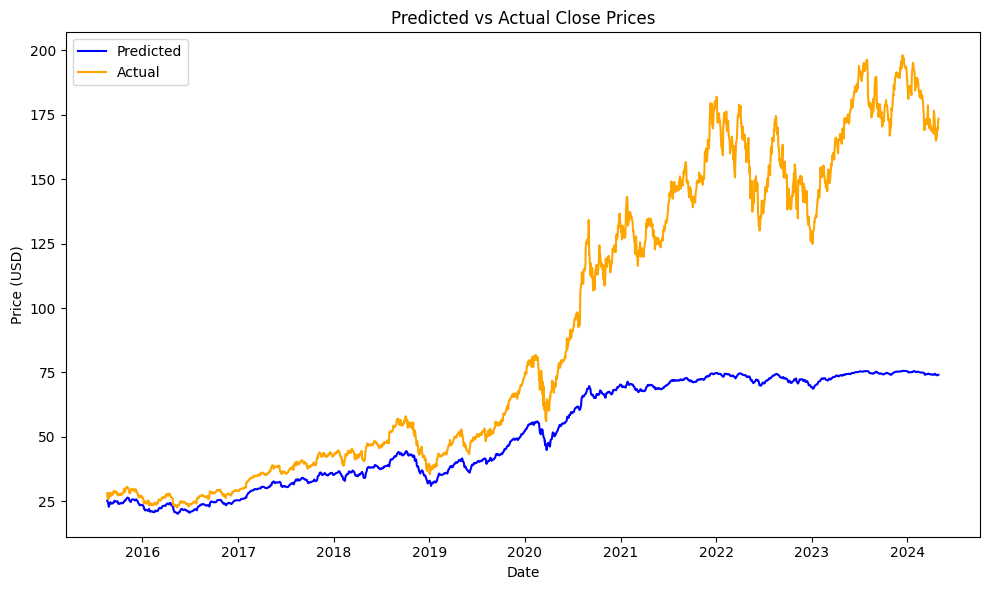

MSE: 3124.6734964865286, RMSE: 55.8987790250067, MAE: 40.310171393571935, MAPE: 32.85433240890942, Direction Accuracy: 49.03934126258005%, R-squared: 0.06106149628464297


In [8]:
# Predict and evaluate
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot predicted vs actual close prices using test data
plt.figure(figsize=(10,6))
plt.plot(data['Date'][split + 3:], predictions, label='Predicted', color='blue')
plt.plot(data['Date'][split + 3:], y_test, label='Actual', color='orange')
plt.title('Predicted vs Actual Close Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
direction_accuracy = (np.sign(y_test[1:] - y_test[:-1]) == np.sign(predictions[1:] - predictions[:-1])).mean()
r_squared = r2_score(y_test, predictions)

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, MAPE: {mape}, Direction Accuracy: {direction_accuracy*100}%, R-squared: {r_squared}')